#### Tecnologie dei dati e del linguaggio
# Significato e contesto
## *You Shall Know a Word by the Company It Keeps*
### Prof. Alfio Ferrara


In [2]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt

## Dataset e nuovo obiettivo
Come esempio, useremo le ricette prese dal dataset [**Food.com Recipes with Search Terms and Tags**](https://www.kaggle.com/datasets/shuyangli94/foodcom-recipes-with-search-terms-and-tags).

Contrariamente al caso della classificazione, cercheremo in questo caso di predire, dato un ingrediente, quali altri ingredienti appaiono nel contesto dell'ingrediente dato.

## Contesto
Possiamo definire il contesto in due modi:
1. **Skip-gram**: ogni ingrediente ha come contesto gli ingredienti che compaiono nella stessa ricetta (eventualmente entro una certa finestra)
2. **Continuous Bag of Words (CBOW)**: a partire dagli ingredienti di una ricetta (entro una finestra), vogliamo predire l'ingrediente centrale

#### Esempio:

Supponiamo di avere una finestra di contesto pari a 2, quindi, per ogni ingrediente, osserviamo i 2 ingredienti prima e dopo.

![](./imgs/context.png)

In [4]:
from collections import defaultdict
import pymongo
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
label_field = 'category'
data = []
labels = ['italian', 'indian', 'southern', 'mexican', 'chinese', 'greek', 'thai']

q = {'search_terms': {'$in': labels}}
for recipe in recipes.find(q):
    data.append({
        'ingredients': recipe['ingredients'],
        label_field: [x for x in recipe['search_terms'] if x in labels][0]
    })

### Creazione del dataset di training

Obiettivo: predire un ingrediente dato il contesto (**CBOW**)

In [6]:
from sklearn.preprocessing import OneHotEncoder
import nltk 
import nlp.wordbags as wb

In [7]:
db = pymongo.MongoClient()['cousine']
recipes = db['foodcom']
corpus = []
q = {}
for recipe in recipes.find(q).limit(15000):
    corpus.append(recipe['ingredients'])

In [8]:
bow = wb.Bow(corpus=corpus, min_occurrences=10)
dataloader, inputs, targets = bow.one_hot_cbow_dataloader(window=4, batch=4)

In [9]:
for x, y in dataloader:
    print(f"Inputs: {x}")
    print(f"Target: {y}")
    print()
    print(f"Inputs shape: {x.shape}")
    print(f"Target shape: {y.shape}")
    for j, row in enumerate(x):
        input_ingredient = [bow.idx2word[i] for i, k in enumerate(row) if k > 0]
        target_ingredients = [bow.idx2word[i] for i, k in enumerate(y[j]) if k > 0]
        print(f"\nIngrediente di input: {input_ingredient}")
        print(f"Ingredienti target: {target_ingredients}\n")
    break 

Inputs: tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])
Target: tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Inputs shape: torch.Size([4, 1308])
Target shape: torch.Size([4, 1308])

Ingrediente di input: ['large shrimp', 'hot pepper sauce']
Ingredienti target: ['red bell pepper']


Ingrediente di input: ['red bell pepper', 'hot pepper sauce']
Ingredienti target: ['large shrimp']


Ingrediente di input: ['red bell pepper', 'large shrimp', 'long grain rice', 'bay leaves']
Ingredienti target: ['hot pepper sauce']


Ingrediente di input: ['hot pepper sauce', 'bay leaves', 'diced tomatoes', 'clam juice', 'fresh parsley']
Ingredienti target: ['long grain rice']



### Rete neurale

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [55]:
class SimpleNet(nn.Module):

    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return x

In [56]:
net = SimpleNet(input_size=len(bow.idx2word), output_size=len(bow.idx2word))

### Train

In [57]:
import time
import math
import torch

In [58]:
def train(document_tensor, label_tensor, criterion, learning_rate):
    net.zero_grad()
    output = net(document_tensor)
    loss = criterion(output, label_tensor)
    loss.backward()

    for p in net.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [59]:
batches = [(doc, lab) for doc, lab in dataloader]

In [60]:
n_iters = 30_000
print_every = 2000
plot_every = 200
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = list(range(1, n_iters + 1))
for it in tqdm(epochs):
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor, criterion, learning_rate)
    current_loss += loss

    if it % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/30000 [00:00<?, ?it/s]

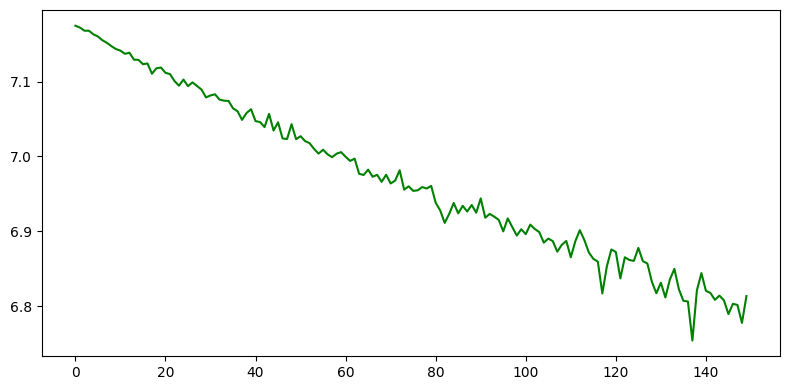

In [61]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g')
plt.tight_layout()
plt.show()

## Predittore

In [62]:
def vectorize(ingredients: list):
    input_vector = [np.zeros(len(bow.vocabulary), dtype=np.float32)]
    for i in ingredients:
        try:
            input_vector[0][bow.word2idx[i]] = 1
        except KeyError:
            pass 
    return torch.tensor(input_vector)

In [63]:
bow.vocabulary

['red bell pepper',
 'large shrimp',
 'hot pepper sauce',
 'long grain rice',
 'bay leaves',
 'diced tomatoes',
 'clam juice',
 'fresh parsley',
 'white beans',
 'canned black beans',
 'white wine vinegar',
 'italian parsley',
 'table salt',
 'zucchini',
 'yellow squash',
 'green bell pepper',
 'italian seasoning',
 'beef stew meat',
 'allspice',
 'dry red wine',
 'beef stock',
 'mushroom',
 'slivered almonds',
 'cider vinegar',
 'ground cumin',
 'ground coriander',
 'cayenne pepper',
 'chicken breasts',
 'green onion',
 'parsley',
 'dijon mustard',
 'salt %26 pepper',
 'potato chips',
 'fresh sage',
 'fresh thyme',
 'asparagus',
 'extra virgin olive oil',
 'potatoes',
 'nutmeg',
 'creamed corn',
 'low sodium chicken broth',
 'lump crabmeat',
 'lean ground beef',
 'ketchup',
 'white vinegar',
 'prepared yellow mustard',
 'onion powder',
 'granulated sugar',
 'whole wheat flour',
 'chocolate chips',
 'margarine',
 'dark brown sugar',
 'egg white',
 'semi-sweet chocolate chips',
 'carrot

In [64]:
ingredients = vectorize(['zucchini', 'spaghetti', 'parmesan cheese'])
with torch.no_grad():
    y_pred = net(ingredients)
    y_pred = F.softmax(y_pred, dim=1)
pd.Series(y_pred[0], index=bow.vocabulary).sort_values(ascending=False).head(10)

fresh parsley             0.003636
extra virgin olive oil    0.003582
parsley                   0.003404
carrots                   0.003260
worcestershire sauce      0.003197
chili powder              0.003093
cornstarch                0.002954
paprika                   0.002921
pecans                    0.002840
carrot                    0.002799
dtype: float32

In [65]:
top20 = pd.Series(y_pred[0], index=bow.vocabulary).sort_values(ascending=False)

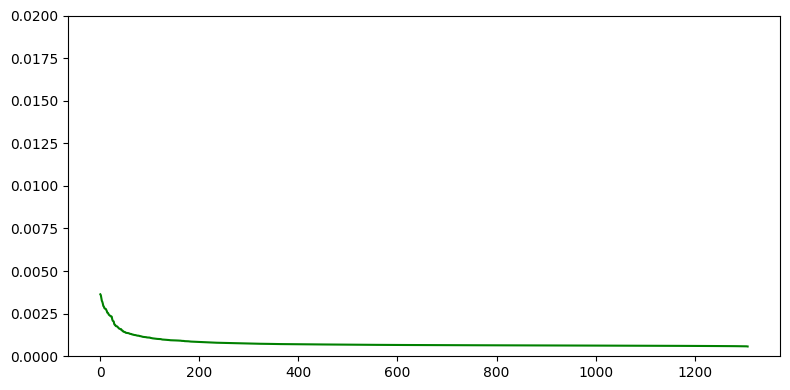

In [66]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(top20.values, 'g')
ax.set_ylim((0, 0.02))
plt.tight_layout()
plt.show()

### Domanda difficile: perchè la rete non impara nulla e attribuisce a tutti gli ingredienti una probabilità così alta?

Partiamo dall'idea che la rete calcola:

$$
\hat{y} = softmax(\theta.T x)
$$

ma dato che $x$ è un vettore one-hot, il prodotto $\theta.T$ non fa altro che selezionare una colonna della matrice dei parametri e aggiornare solo quella. In pratica calcoliamo solo:

$$
\hat{y} = softmax(\theta.T x_i)
$$

QUindi tutti i vettori di input si appiattiscono in modo simile, e softmax dà sempre una distribuzione simile. Tutte le probabilità si avvicinano e nessuna parola viene predetta correttamente.

## Alcune considerazioni sui parametri della rete.

In [67]:
print([x for x in net.named_parameters()])

[('fc.weight', Parameter containing:
tensor([[-0.0003,  0.0278,  0.0110,  ..., -0.0237, -0.0175, -0.0189],
        [ 0.0303, -0.0136,  0.0286,  ...,  0.0079,  0.0115, -0.0212],
        [-0.0072,  0.0193, -0.0255,  ...,  0.0085, -0.0260, -0.0243],
        ...,
        [-0.0037,  0.0013,  0.0022,  ...,  0.0093,  0.0039,  0.0044],
        [-0.0014, -0.0028, -0.0122,  ..., -0.0062, -0.0052, -0.0185],
        [-0.0007, -0.0184,  0.0259,  ...,  0.0272,  0.0020,  0.0199]],
       requires_grad=True)), ('fc.bias', Parameter containing:
tensor([ 0.9525, -0.0386,  0.1288,  ..., -0.1574, -0.1810, -0.1398],
       requires_grad=True))]


In [68]:
params = {name: param.detach().numpy() for name, param in net.named_parameters()}

In [69]:
params['fc.weight'].shape

(1308, 1308)

In [70]:

feature_vectors = pd.DataFrame(params['fc.weight'].T, index=bow.vocabulary, columns=bow.vocabulary)
feature_vectors

,red bell pepper,large shrimp,hot pepper sauce,long grain rice,bay leaves,diced tomatoes,clam juice,fresh parsley,white beans,canned black beans,...,oleo,fat-free ricotta cheese,instant chocolate pudding mix,pork,lipton onion soup mix,tomato ketchup,dark red kidney beans,nonfat plain yogurt,prunes,corn kernels
red bell pepper,-0.000279,0.030343,-0.007228,-0.007412,-0.026453,0.027906,0.003539,-0.012356,-0.007989,0.009104,...,-0.021117,0.024972,0.011963,-0.026714,-0.015080,-0.022109,0.003670,-0.003662,-0.001413,-0.000687
large shrimp,0.027824,-0.013619,0.019254,-0.026987,0.002690,0.006647,0.015788,0.026642,-0.001096,-0.022733,...,-0.025082,0.011715,0.008618,-0.006472,0.025398,0.010050,0.000200,0.001305,-0.002780,-0.018442
hot pepper sauce,0.011005,0.028640,-0.025520,0.025198,-0.009420,0.014857,-0.007840,0.024735,0.026540,-0.022937,...,0.018674,-0.004258,-0.013679,-0.007740,-0.002679,0.026121,-0.010685,0.002153,-0.012191,0.025892
long grain rice,0.004625,0.008982,0.018841,0.007113,0.000751,0.018396,0.019490,0.019721,-0.006900,0.002084,...,0.008074,0.022989,0.007398,0.016996,-0.025954,-0.015302,0.000543,-0.010059,0.021586,-0.006129
bay leaves,0.000012,0.016178,-0.021899,0.011265,0.021216,-0.003991,-0.021075,0.039603,-0.021605,0.024203,...,-0.024364,-0.003272,0.010834,0.019182,-0.011223,-0.018734,-0.024348,0.009835,0.009592,0.021448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tomato ketchup,-0.007659,0.003328,0.006446,0.024472,0.017535,0.023308,-0.024669,-0.022147,0.006698,-0.007165,...,-0.006722,0.005927,-0.011345,0.014648,-0.009157,-0.001781,-0.021225,-0.009002,0.024809,0.002430
dark red kidney beans,0.038894,-0.007548,0.023405,-0.013417,0.022158,0.046227,0.003026,0.014530,-0.006264,0.020313,...,0.003947,0.022483,-0.014062,0.022223,0.017773,0.007508,-0.018398,0.023125,0.025632,-0.003750
nonfat plain yogurt,-0.023655,0.007942,0.008539,-0.020047,-0.019263,0.026610,0.015531,0.015985,0.004815,0.022663,...,0.006851,0.016313,0.025321,-0.022679,-0.007937,0.005897,-0.012918,0.009347,-0.006166,0.027150
prunes,-0.017487,0.011522,-0.025951,0.005380,0.023365,0.011856,-0.012488,0.019299,0.007088,0.014804,...,-0.026666,0.026694,-0.012934,-0.019895,-0.008923,0.003126,-0.014354,0.003900,-0.005181,0.001992


Ora, proviamo a calcolare la similarità tra ingredienti utilizzando questi vettori.

In [71]:
from sklearn.metrics.pairwise import cosine_similarity

In [72]:
sigma = cosine_similarity(feature_vectors, feature_vectors)
S = pd.DataFrame(sigma, index=bow.vocabulary, columns=bow.vocabulary)

In [73]:
S.head()

,red bell pepper,large shrimp,hot pepper sauce,long grain rice,bay leaves,diced tomatoes,clam juice,fresh parsley,white beans,canned black beans,...,oleo,fat-free ricotta cheese,instant chocolate pudding mix,pork,lipton onion soup mix,tomato ketchup,dark red kidney beans,nonfat plain yogurt,prunes,corn kernels
red bell pepper,1.000000,-0.010841,0.030387,0.024631,0.029817,0.046809,-0.034368,0.108634,-0.001495,0.024357,...,0.001391,-0.009602,0.030190,-0.031369,-0.001367,0.042730,0.066359,0.020309,0.031357,-0.033537
large shrimp,-0.010841,1.000000,0.025255,-0.049588,0.008829,0.010055,0.034195,-0.000952,-0.002393,-0.012710,...,0.002135,0.004435,0.013346,-0.002937,-0.000451,0.005102,-0.028861,-0.011962,-0.018271,0.017547
hot pepper sauce,0.030387,0.025255,0.999999,0.049158,0.057474,0.057776,0.034303,0.040892,-0.012008,0.000876,...,-0.025386,-0.003099,-0.027380,-0.011743,0.015842,-0.032966,-0.010703,-0.011159,0.025664,0.020406
long grain rice,0.024631,-0.049588,0.049158,1.000000,0.047357,-0.020546,0.038985,0.071084,0.022750,0.021090,...,0.048145,-0.003453,-0.045927,0.024318,0.000246,0.024116,0.028842,0.015425,-0.027772,0.018334
bay leaves,0.029817,0.008829,0.057474,0.047357,1.000000,0.043424,-0.001220,0.090621,0.010428,-0.018600,...,0.003054,0.003858,0.033932,0.022263,-0.029537,0.047954,0.027247,0.022122,0.051424,0.001196


In [74]:
query = 'soy sauce'
S.loc[query].sort_values(ascending=False).head(10)

soy sauce               1.000001
sesame oil              0.215761
fresh ginger            0.196096
green onions            0.172736
worcestershire sauce    0.161537
cornstarch              0.151419
carrot                  0.140171
ginger                  0.133360
curry powder            0.116225
low sodium soy sauce    0.114468
Name: soy sauce, dtype: float32

## Introduzione di un layer intermedio (hidden layer)
![](./imgs/hidden.png)

In [75]:
class HiddenNet(nn.Module):

    def __init__(self, input_size, output_size, hidden_size):
        super(HiddenNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [76]:
net = HiddenNet(input_size=len(bow.idx2word), output_size=len(bow.idx2word), hidden_size=10)

In [77]:
n_iters = 50_000
print_every = 2000
plot_every = 200
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

epochs = list(range(1, n_iters + 1))
for it in tqdm(epochs):
    document_tensor, label_tensor = batches[np.random.randint(0, len(batches) - 1)]
    output, loss = train(document_tensor, label_tensor, criterion, learning_rate)
    current_loss += loss

    if it % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

  0%|          | 0/50000 [00:00<?, ?it/s]

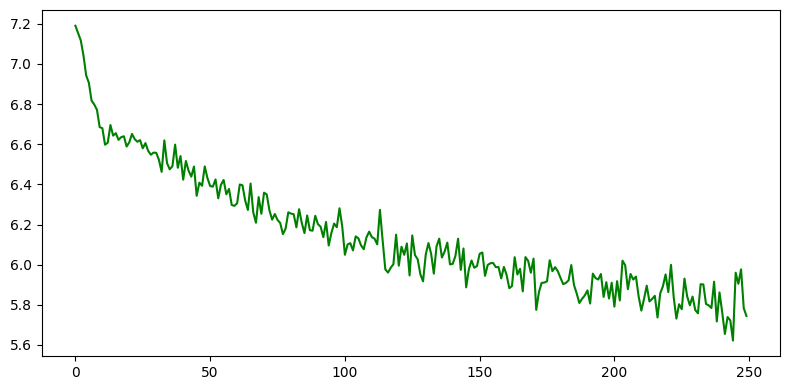

In [78]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(all_losses, 'g')
plt.tight_layout()
plt.show()

In [79]:
ingredients = vectorize(['zucchini', 'spaghetti', 'parmesan cheese'])
with torch.no_grad():
    y_pred = net(ingredients)
    y_pred = F.softmax(y_pred, dim=1)
pd.Series(y_pred[0], index=bow.vocabulary).sort_values(ascending=False)


bacon                        0.035926
carrot                       0.033864
extra virgin olive oil       0.026258
zucchini                     0.025667
ground beef                  0.020905
                               ...   
strong coffee                0.000016
frozen blueberries           0.000016
ground allspice              0.000015
splenda brown sugar blend    0.000014
ground coriander             0.000012
Length: 1308, dtype: float32

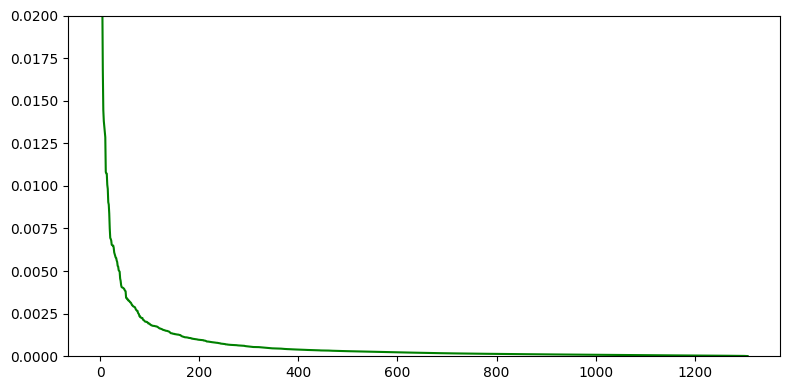

In [80]:
top20 = pd.Series(y_pred[0], index=bow.vocabulary).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(top20.values, 'g')
ax.set_ylim((0, 0.02))
plt.tight_layout()
plt.show()

## Prendiamo i primi valori per ottenere un embedding di dimensione pari all'hidden layer per ogni ingrediente

### Domanda: è chiaro perchè la matrice ha questa dimensione?

In [85]:
params = {name: param.detach().numpy() for name, param in net.named_parameters()}
feature_vectors = pd.DataFrame(params['fc1.weight'].T, index=bow.vocabulary)
feature_vectors

,0,1,2,3,4,5,6,7,8,9
red bell pepper,0.131051,0.263593,-0.992666,-0.007109,-0.419115,0.079411,1.356436,0.773403,0.244165,0.235436
large shrimp,-0.068020,0.122012,-0.261390,-0.690944,-0.532414,-0.213286,-0.497533,-0.443966,-0.591092,-0.346649
hot pepper sauce,-0.109674,-0.223237,-0.591564,-0.413040,-0.269676,0.124563,0.120504,-0.233352,0.294474,0.314098
long grain rice,0.183065,-0.023075,-0.373053,-0.331689,-0.350438,0.258613,0.001039,0.167682,0.271685,0.020731
bay leaves,0.200965,-0.281540,-0.840482,-0.583812,-0.817870,-0.109424,0.057329,0.287009,0.640643,-0.720780
...,...,...,...,...,...,...,...,...,...,...
tomato ketchup,-0.080662,0.018943,-0.020359,0.000595,-0.570608,0.400625,-0.013427,0.105217,0.379407,0.077704
dark red kidney beans,-0.144646,-0.001654,-0.192032,-0.513527,0.162703,0.312059,0.276365,-0.062937,-0.297290,-0.004674
nonfat plain yogurt,-0.092913,0.098661,0.040854,-0.055468,-0.140470,-0.136623,-0.068681,-0.031024,0.066282,-0.102527
prunes,-0.085918,0.158850,0.047851,0.084656,-0.245938,-0.110251,0.068291,0.026020,0.116982,-0.032434


In [94]:
sigma = cosine_similarity(feature_vectors, feature_vectors)
S = pd.DataFrame(sigma, index=bow.vocabulary, columns=bow.vocabulary)
S

,red bell pepper,large shrimp,hot pepper sauce,long grain rice,bay leaves,diced tomatoes,clam juice,fresh parsley,white beans,canned black beans,...,oleo,fat-free ricotta cheese,instant chocolate pudding mix,pork,lipton onion soup mix,tomato ketchup,dark red kidney beans,nonfat plain yogurt,prunes,corn kernels
red bell pepper,1.000000,-0.285962,0.409620,0.513744,0.427396,0.083490,-0.225671,0.576721,-0.106093,0.081671,...,-0.623593,0.326523,-0.003683,0.348205,0.040554,0.291184,0.251122,-0.184982,0.293868,0.457554
large shrimp,-0.285962,1.000000,0.230371,0.196186,0.329182,0.349060,0.555694,0.061837,0.552410,-0.277468,...,-0.141631,0.204862,-0.464926,0.473502,0.088653,-0.055305,0.312437,0.504116,0.010630,0.279789
hot pepper sauce,0.409620,0.230371,1.000000,0.708714,0.545798,0.273658,-0.056606,0.449469,0.120497,-0.351154,...,-0.248192,0.049613,-0.651826,0.492382,0.297890,0.424288,0.392615,-0.021593,-0.029178,0.541910
long grain rice,0.513744,0.196186,0.708714,1.000000,0.791681,0.600234,0.036171,0.557296,0.408221,0.068782,...,-0.542779,0.244272,-0.403031,0.520819,0.552552,0.681288,0.249136,0.038535,0.100168,0.468823
bay leaves,0.427396,0.329182,0.545798,0.791681,1.000000,0.259307,0.391035,0.663800,0.293094,-0.365437,...,-0.204313,0.225131,-0.263111,0.368407,0.351694,0.463483,0.057369,0.381475,0.275706,0.160516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tomato ketchup,0.291184,-0.055305,0.424288,0.681288,0.463483,0.309844,-0.005664,0.036021,0.049007,0.123892,...,-0.333498,-0.310094,-0.013448,0.443505,0.675529,1.000000,-0.119979,0.210322,0.501155,0.007226
dark red kidney beans,0.251122,0.312437,0.392615,0.249136,0.057369,0.624977,-0.366023,0.143171,0.350128,0.049501,...,-0.296760,0.386600,-0.580155,0.247996,0.378638,-0.119979,1.000000,-0.302086,-0.459868,0.394246
nonfat plain yogurt,-0.184982,0.504116,-0.021593,0.038535,0.381475,-0.077555,0.437747,0.155383,0.300145,-0.314182,...,-0.013356,0.071105,0.343957,0.178671,0.163925,0.210322,-0.302086,1.000000,0.723487,-0.402429
prunes,0.293868,0.010630,-0.029178,0.100168,0.275706,-0.282586,0.183110,0.156514,-0.128387,-0.111063,...,-0.303789,-0.100781,0.543769,0.239591,0.109425,0.501155,-0.459868,0.723487,1.000000,-0.272726


In [97]:
query = 'soy sauce'
S.loc[query].sort_values(ascending=False).head(10)

soy sauce                   1.000000
reduced sodium soy sauce    0.904264
low sodium soy sauce        0.900257
dark soy sauce              0.877426
rice wine                   0.819645
light soy sauce             0.816500
light cream                 0.762562
soya sauce                  0.753781
mirin                       0.753729
peanut oil                  0.744458
Name: soy sauce, dtype: float32